# 🎵 Music Genre Classification - EDA & Model Training

## Project Overview

This notebook provides a comprehensive analysis of the **GTZAN Dataset** for music genre classification. We'll cover:

1. **How Audio Becomes Data** - Understanding feature extraction from audio signals
2. **Exploratory Data Analysis (EDA)** - Visualizing audio characteristics and feature distributions
3. **Model Selection** - Comparing multiple ML algorithms with cross-validation
4. **Hyperparameter Tuning** - GridSearchCV for optimal model performance
5. **Evaluation** - Confusion matrices, classification reports, and error analysis

### The GTZAN Dataset
- **1000 audio tracks** (30 seconds each)
- **10 genres**: Blues, Classical, Country, Disco, Hip-hop, Jazz, Metal, Pop, Reggae, Rock
- **100 tracks per genre** (balanced dataset)
- **Pre-extracted features**: 57 audio features per track

---

## 1. Import Required Libraries

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# Audio processing
import librosa
import librosa.display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# Model persistence
import joblib
import pickle

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ All libraries imported successfully!")
print(f"Librosa version: {librosa.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

✅ All libraries imported successfully!
Librosa version: 0.11.0
Scikit-learn version: 1.8.0


## 2. Load and Explore the Dataset

In [2]:
# Define paths - adjust if running from different location
# If running from notebooks folder:
BASE_DIR = os.path.dirname(os.getcwd()) if 'notebooks' in os.getcwd() else os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, 'data')
ARTIFACTS_DIR = os.path.join(BASE_DIR, 'artifacts')

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")

# Load the 30-second features dataset
df = pd.read_csv(os.path.join(DATA_DIR, 'features_30_sec.csv'))

print(f"\n📊 Dataset Shape: {df.shape}")
print(f"\n📁 Columns ({len(df.columns)}):")
print(df.columns.tolist())

df.head()

Base directory: c:\Users\awaco\Downloads\MLDeploy-main\MLDeploy-main
Data directory: c:\Users\awaco\Downloads\MLDeploy-main\MLDeploy-main\data

📊 Dataset Shape: (1000, 60)

📁 Columns (60):
['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean', 'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var', 'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean', 'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var', 'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo', 'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean', 'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var', 'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean', 'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var', 'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean', 'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var', 'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfc

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# Basic dataset info
print("=" * 60)
print("DATASET INFORMATION")
print("=" * 60)

print(f"\n📊 Shape: {df.shape[0]} samples x {df.shape[1]} features")
print(f"\n🎵 Genres: {df['label'].nunique()}")
print(df['label'].unique())

print(f"\n📈 Data Types:")
print(df.dtypes.value_counts())

print(f"\n❌ Missing Values:")
missing = df.isnull().sum().sum()
print(f"Total missing values: {missing}")

print(f"\n📉 Basic Statistics:")
df.describe()

DATASET INFORMATION

📊 Shape: 1000 samples x 60 features

🎵 Genres: 10
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

📈 Data Types:
float64    57
object      2
int64       1
Name: count, dtype: int64

❌ Missing Values:
Total missing values: 0

📉 Basic Statistics:


,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,662030.846000,0.378682,0.086340,0.130930,0.003051,2201.780898,4.696916e+05,2242.541070,137079.155165,4571.549304,...,1.148144,60.730958,-3.966028,62.633624,0.507696,63.712586,-2.328761,66.231930,-1.095348,70.126096
std,1784.073992,0.081705,0.007735,0.065683,0.003634,715.960600,4.008995e+05,526.316473,96455.666326,1574.791602,...,4.578948,33.781951,4.549697,33.479172,3.869105,34.401977,3.755957,37.174631,3.837007,45.228512
min,660000.000000,0.171939,0.044555,0.005276,0.000004,570.040355,7.911251e+03,898.066208,10787.185064,749.140636,...,-15.693844,9.169314,-17.234728,13.931521,-11.963694,15.420555,-18.501955,13.487622,-19.929634,7.956583
25%,661504.000000,0.319562,0.082298,0.086657,0.000942,1627.697311,1.843505e+05,1907.240605,67376.554428,3380.069642,...,-1.863280,40.376442,-7.207225,40.830875,-2.007015,41.884240,-4.662925,41.710184,-3.368996,42.372865
50%,661794.000000,0.383148,0.086615,0.122443,0.001816,2209.263090,3.384862e+05,2221.392843,111977.548036,4658.524473,...,1.212809,52.325077,-4.065605,54.717674,0.669643,54.804890,-2.393862,57.423059,-1.166289,59.186117
75%,661794.000000,0.435942,0.091256,0.175682,0.003577,2691.294667,6.121479e+05,2578.469836,182371.576801,5533.810460,...,4.359662,71.691755,-0.838737,75.040838,3.119212,75.385832,0.150573,78.626444,1.312615,85.375374
max,675808.000000,0.663685,0.108111,0.397973,0.027679,4435.243901,3.036843e+06,3509.646417,694784.811549,8677.672688,...,13.457150,392.932373,11.482946,406.058868,15.388390,332.905426,14.694924,393.161987,15.369627,506.065155


## 3. Exploratory Data Analysis (EDA)

### 3.1 Class Distribution
A balanced dataset is crucial for classification. Let's verify the genre distribution.

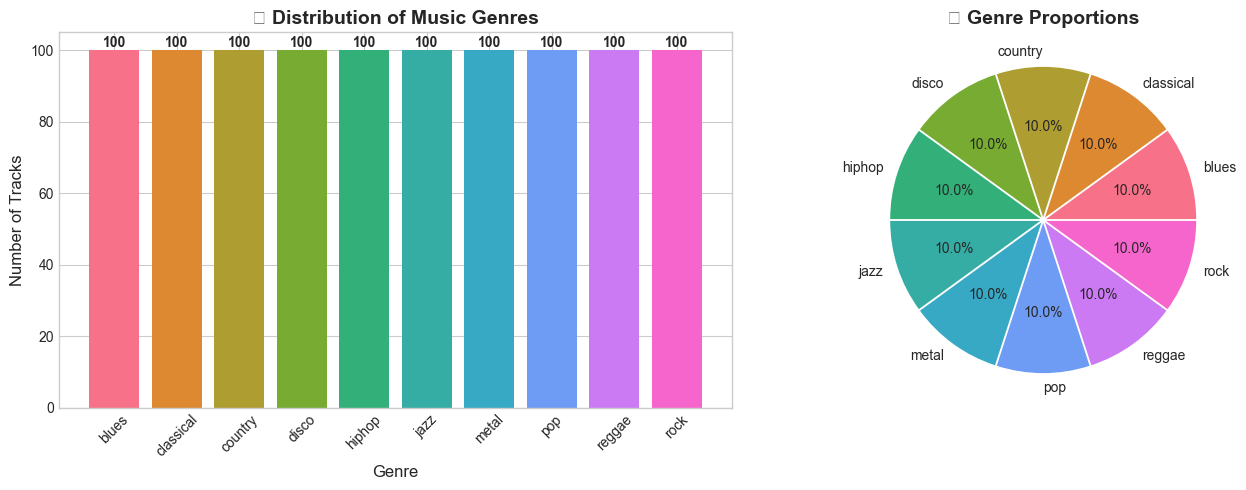


✅ Dataset is perfectly balanced: 100 samples per genre


In [4]:
# Genre distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
genre_counts = df['label'].value_counts()
colors = sns.color_palette('husl', n_colors=10)
axes[0].bar(genre_counts.index, genre_counts.values, color=colors)
axes[0].set_xlabel('Genre', fontsize=12)
axes[0].set_ylabel('Number of Tracks', fontsize=12)
axes[0].set_title('🎵 Distribution of Music Genres', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(genre_counts.values):
    axes[0].text(i, v + 1, str(v), ha='center', fontweight='bold')

# Pie chart
axes[1].pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', 
            colors=colors, explode=[0.02]*10)
axes[1].set_title('🎵 Genre Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset is perfectly balanced: {genre_counts.values[0]} samples per genre")

### 3.2 How Audio Becomes Data - Feature Extraction Explained

Audio signals are transformed into numerical features that machine learning models can process. Here's how:

#### Key Audio Features:

| Feature | Description | Why It Matters |
|---------|-------------|----------------|
| **MFCCs** (Mel-Frequency Cepstral Coefficients) | Represents the short-term power spectrum | Captures timbral texture, most important for genre |
| **Spectral Centroid** | "Center of mass" of the spectrum | Indicates brightness of sound |
| **Spectral Bandwidth** | Width of the spectrum | Measures frequency spread |
| **Spectral Rolloff** | Frequency below which 85% of energy is contained | Distinguishes harmonic vs noisy sounds |
| **Zero Crossing Rate** | Rate of sign changes in the signal | Higher for percussive, noisy sounds |
| **Chroma Features** | Energy distribution across 12 pitch classes | Captures harmonic/melodic content |
| **RMS Energy** | Root mean square energy | Measures loudness |
| **Tempo** | Beats per minute | Rhythm characteristic |

In [5]:
# Visualize audio features from a sample track
sample_genres = ['classical', 'metal', 'hiphop', 'jazz']
audio_dir = os.path.join(DATA_DIR, 'genres_original')

# Check if audio files exist
if os.path.exists(audio_dir):
    fig, axes = plt.subplots(len(sample_genres), 4, figsize=(20, 4*len(sample_genres)))
    fig.suptitle('🎵 Audio Visualization Across Genres', fontsize=16, fontweight='bold', y=1.02)

    for i, genre in enumerate(sample_genres):
        genre_dir = os.path.join(audio_dir, genre)
        if os.path.exists(genre_dir):
            audio_files = [f for f in os.listdir(genre_dir) if f.endswith('.wav')]
            if audio_files:
                audio_path = os.path.join(genre_dir, audio_files[0])
                y, sr = librosa.load(audio_path, duration=10)
                
                # 1. Waveform
                librosa.display.waveshow(y, sr=sr, ax=axes[i, 0], color=colors[i])
                axes[i, 0].set_title(f'{genre.upper()} - Waveform')
                axes[i, 0].set_xlabel('Time (s)')
                
                # 2. Spectrogram
                D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
                librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[i, 1])
                axes[i, 1].set_title(f'{genre.upper()} - Spectrogram')
                
                # 3. Mel Spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
                mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
                librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', ax=axes[i, 2])
                axes[i, 2].set_title(f'{genre.upper()} - Mel Spectrogram')
                
                # 4. MFCCs
                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                librosa.display.specshow(mfccs, x_axis='time', ax=axes[i, 3])
                axes[i, 3].set_title(f'{genre.upper()} - MFCCs')
                axes[i, 3].set_ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()
    
    print("\n📊 Notice how different genres have distinct visual patterns:")
    print("  • Classical: Smooth waveforms, concentrated low frequencies")
    print("  • Metal: High amplitude, broad frequency spectrum")
    print("  • Hip-hop: Strong beats, rhythmic patterns")
    print("  • Jazz: Complex harmonic content, varied dynamics")
else:
    print("⚠️ Audio files not found. Using pre-extracted features only.")
    print("   This is fine - we have all features in the CSV!")

⚠️ Audio files not found. Using pre-extracted features only.
   This is fine - we have all features in the CSV!


### 3.3 Feature Distribution Analysis

Let's examine how key features are distributed across genres.

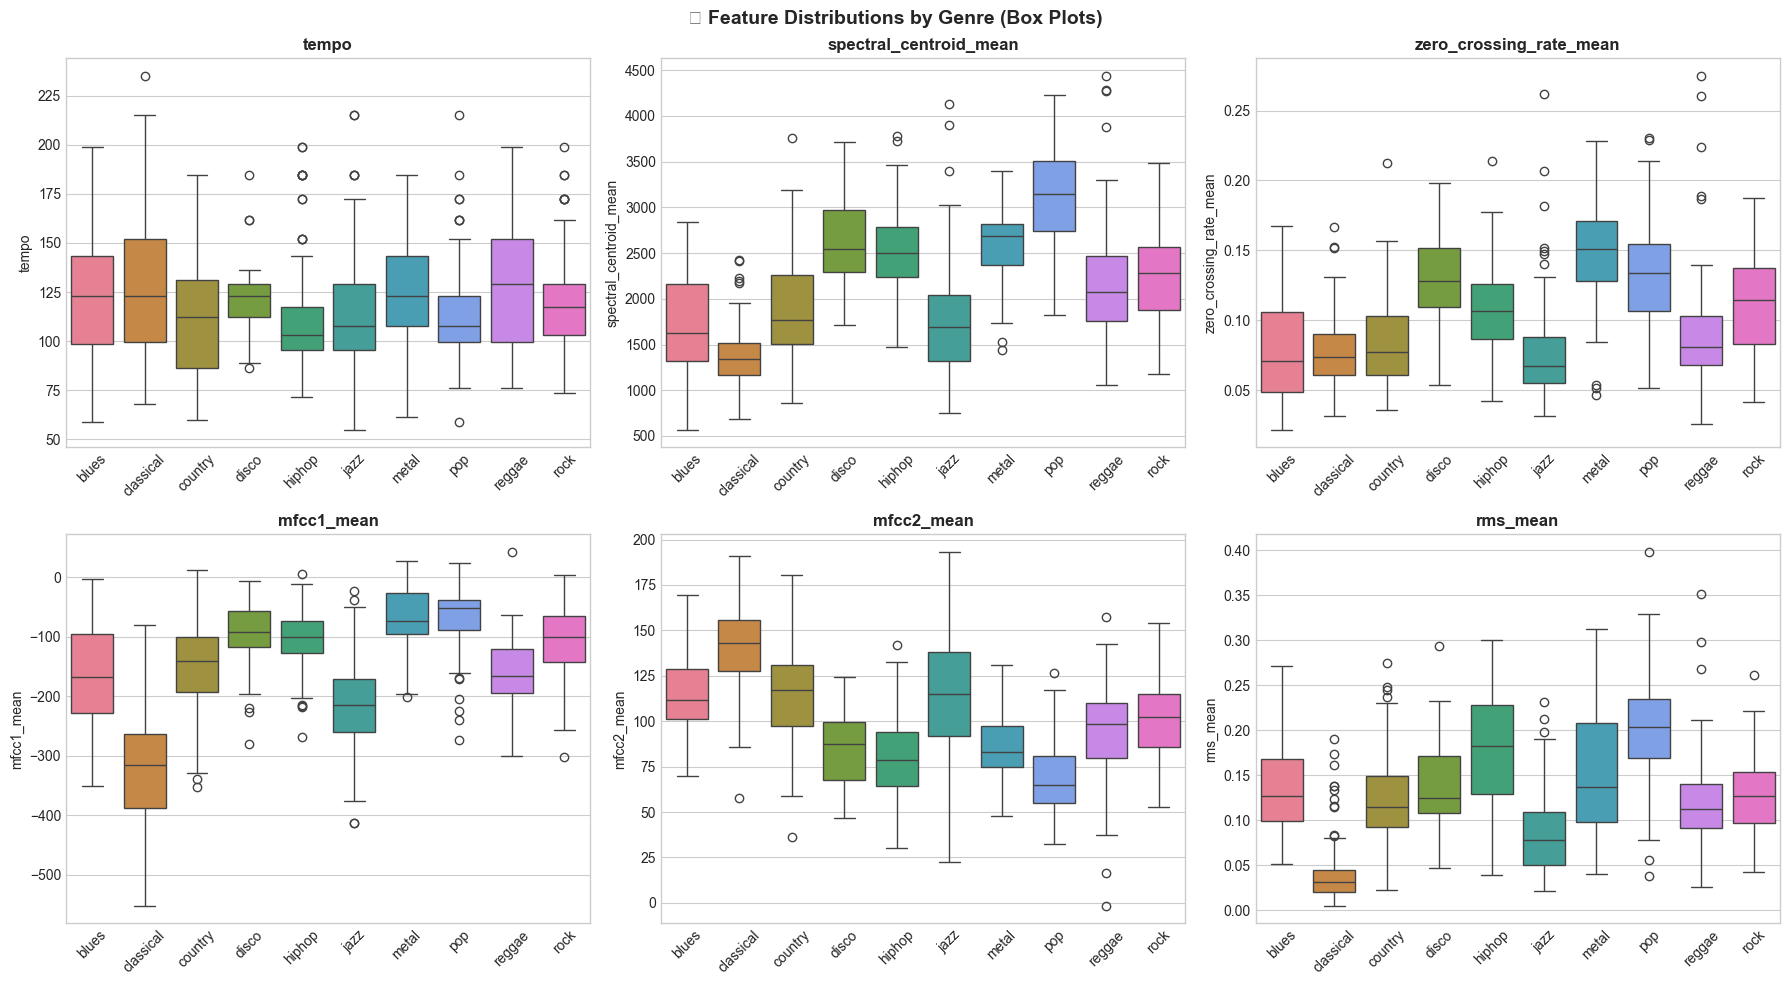


📊 Key Observations:
  • Tempo: Metal and Disco tend to have higher tempos
  • Spectral Centroid: Metal has higher values (brighter sound)
  • Zero Crossing Rate: Metal and Rock have higher ZCR (noisier)
  • MFCC values vary significantly across genres


In [6]:
# Box plots for key features by genre
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

features_boxplot = ['tempo', 'spectral_centroid_mean', 'zero_crossing_rate_mean', 
                    'mfcc1_mean', 'mfcc2_mean', 'rms_mean']

for idx, feature in enumerate(features_boxplot):
    sns.boxplot(data=df, x='label', y=feature, ax=axes[idx], palette='husl')
    axes[idx].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_xlabel('')

plt.suptitle('🎵 Feature Distributions by Genre (Box Plots)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print("  • Tempo: Metal and Disco tend to have higher tempos")
print("  • Spectral Centroid: Metal has higher values (brighter sound)")
print("  • Zero Crossing Rate: Metal and Rock have higher ZCR (noisier)")
print("  • MFCC values vary significantly across genres")

### 3.4 Correlation Analysis

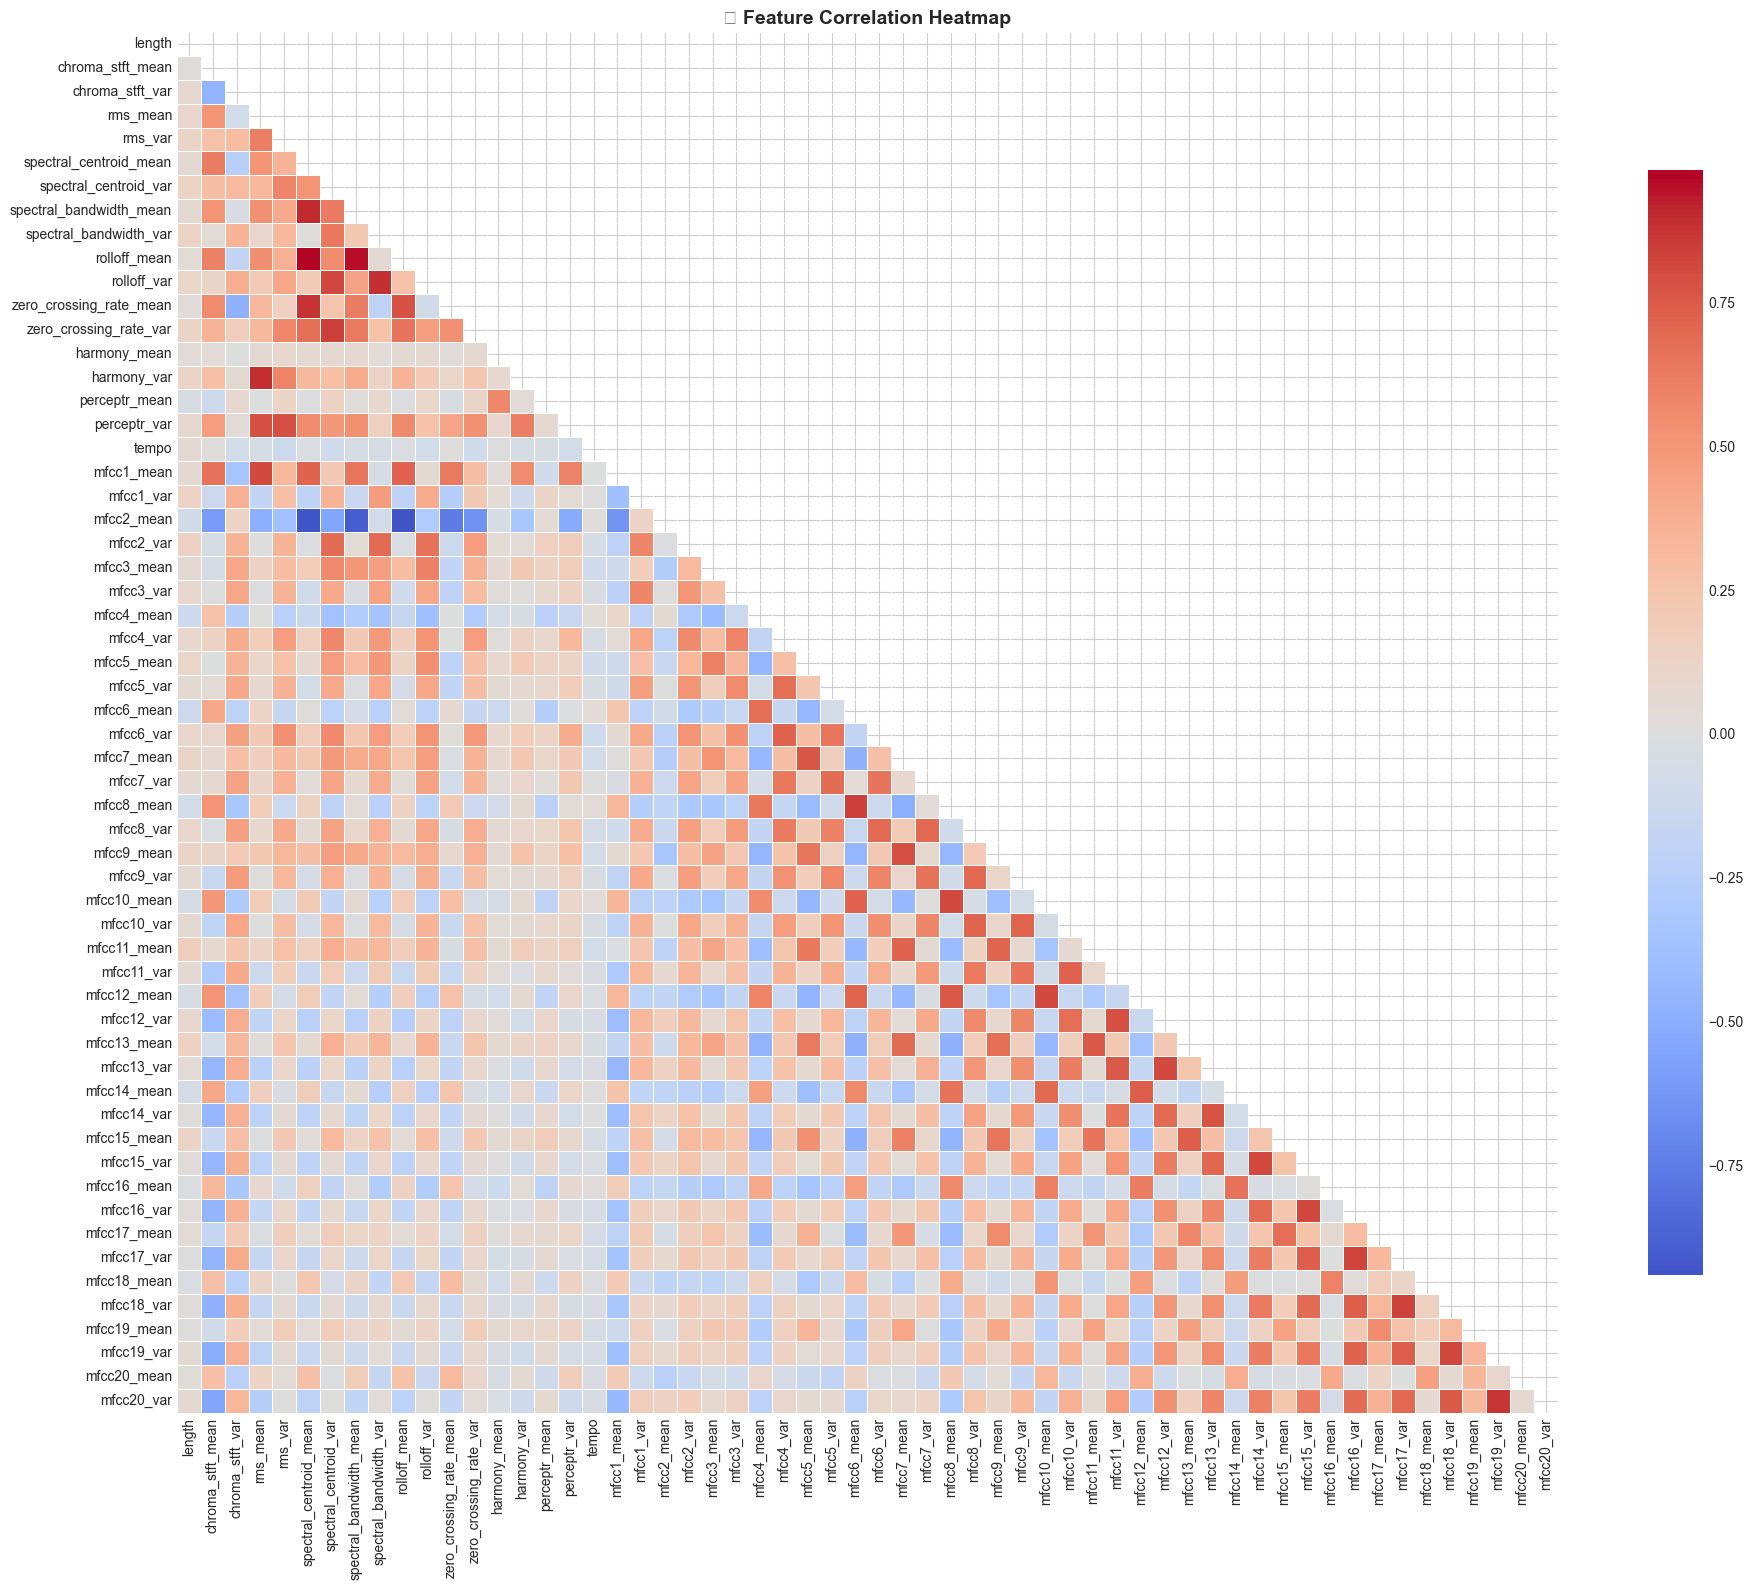


⚠️ Highly Correlated Features (|r| > 0.9): 5 pairs
  spectral_centroid_mean <-> spectral_bandwidth_mean: 0.904
  spectral_centroid_mean <-> rolloff_mean: 0.980
  spectral_centroid_mean <-> mfcc2_mean: -0.940
  spectral_bandwidth_mean <-> rolloff_mean: 0.956
  rolloff_mean <-> mfcc2_mean: -0.934


In [7]:
# Define feature columns (excluding filename and label)
feature_cols = [col for col in df.columns if col not in ['filename', 'label']]

# Correlation matrix
corr_matrix = df[feature_cols].corr()

# Plot heatmap
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('🔗 Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated features
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print(f"\n⚠️ Highly Correlated Features (|r| > 0.9): {len(high_corr_pairs)} pairs")
for f1, f2, r in high_corr_pairs[:10]:
    print(f"  {f1} <-> {f2}: {r:.3f}")

### 3.5 Dimensionality Reduction Visualization (PCA & t-SNE)

Running t-SNE (this may take a moment)...


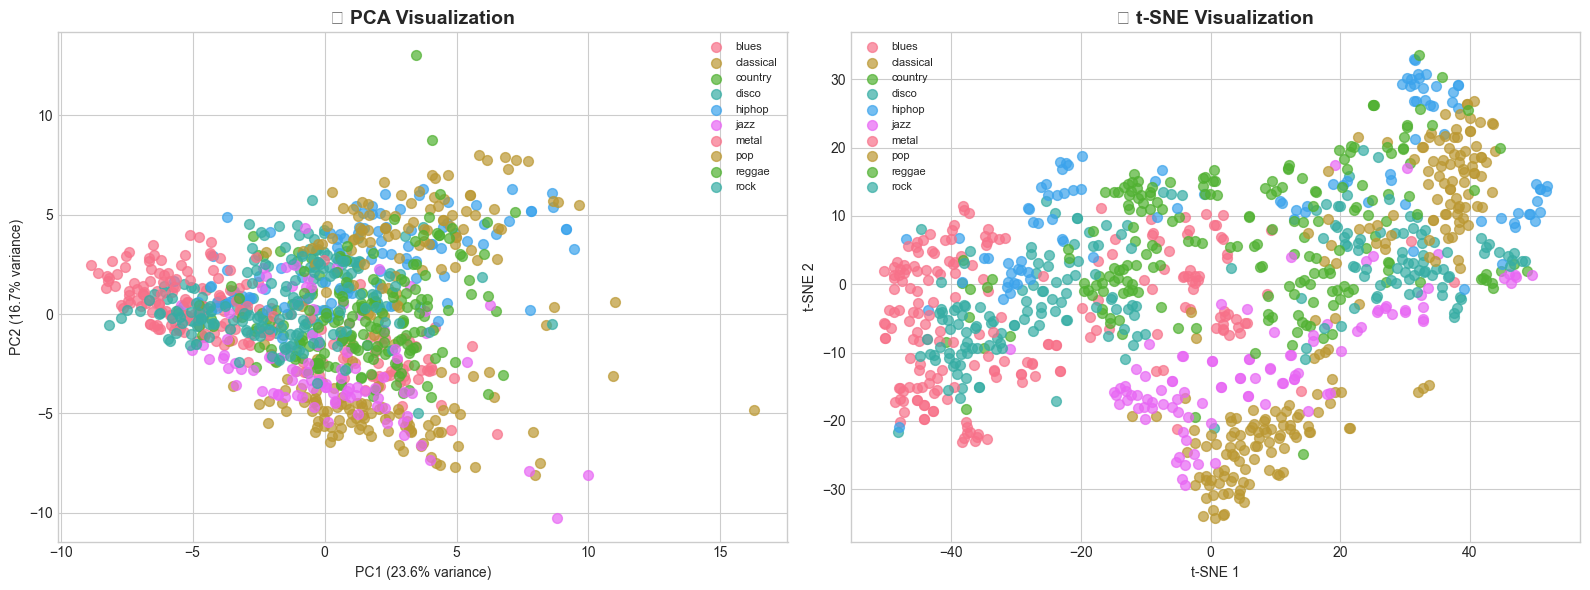


📊 PCA explains 40.2% of variance with 2 components

🔍 Observations:
  • Some genres form distinct clusters (Classical, Metal)
  • Others overlap significantly (Rock, Country, Pop)
  • This suggests some genres will be harder to classify


In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Prepare data
X = df[feature_cols].values
y = df['label'].values

# Scale features
scaler_viz = StandardScaler()
X_scaled = scaler_viz.fit_transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# t-SNE
print("Running t-SNE (this may take a moment)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA plot
for genre in np.unique(y):
    mask = y == genre
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], label=genre, alpha=0.7, s=50)
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].set_title('🎯 PCA Visualization', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=8)

# t-SNE plot
for genre in np.unique(y):
    mask = y == genre
    axes[1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], label=genre, alpha=0.7, s=50)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('🎯 t-SNE Visualization', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()

print(f"\n📊 PCA explains {sum(pca.explained_variance_ratio_[:2])*100:.1f}% of variance with 2 components")
print("\n🔍 Observations:")
print("  • Some genres form distinct clusters (Classical, Metal)")
print("  • Others overlap significantly (Rock, Country, Pop)")
print("  • This suggests some genres will be harder to classify")

## 4. Data Preprocessing

### 4.1 Prepare Features and Labels

In [15]:
# Feature columns (57 features)
FEATURE_COLUMNS = [col for col in df.columns if col not in ['filename', 'label']]
print(f"Number of features: {len(FEATURE_COLUMNS)}")

# Extract features and labels
X = df[FEATURE_COLUMNS].values
y = df['label'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nGenres: {np.unique(y)}")

# Check for NaN or infinite values
print(f"\n❌ NaN values in X: {np.isnan(X).sum()}")
print(f"❌ Infinite values in X: {np.isinf(X).sum()}")

Number of features: 58

Feature matrix shape: (1000, 58)
Labels shape: (1000,)

Genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']

❌ NaN values in X: 0
❌ Infinite values in X: 0


### 4.2 Encode Labels and Scale Features

In [16]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Label Encoding:")
for i, genre in enumerate(label_encoder.classes_):
    print(f"  {genre}: {i}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Features scaled (mean=0, std=1)")
print(f"X_scaled shape: {X_scaled.shape}")
print(f"Sample scaled values: {X_scaled[0, :5]}")

# Save feature names for later
feature_names = FEATURE_COLUMNS

Label Encoding:
  blues: 0
  classical: 1
  country: 2
  disco: 3
  hiphop: 4
  jazz: 5
  metal: 6
  pop: 7
  reggae: 8
  rock: 9

✅ Features scaled (mean=0, std=1)
X_scaled shape: (1000, 58)
Sample scaled values: [-0.13282213 -0.35013678  0.31258717 -0.01068969 -0.06185589]


### 4.3 Train-Test Split

In [17]:
# Stratified split to maintain genre proportions
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded  # Important: maintain class distribution
)

print(f"📊 Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_scaled)*100:.0f}%)")
print(f"📊 Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_scaled)*100:.0f}%)")

# Verify stratification
print("\n✅ Class distribution in splits:")
train_dist = np.bincount(y_train) / len(y_train) * 100
test_dist = np.bincount(y_test) / len(y_test) * 100
for i, genre in enumerate(label_encoder.classes_):
    print(f"  {genre}: Train={train_dist[i]:.1f}%, Test={test_dist[i]:.1f}%")

📊 Training set: 800 samples (80%)
📊 Test set: 200 samples (20%)

✅ Class distribution in splits:
  blues: Train=10.0%, Test=10.0%
  classical: Train=10.0%, Test=10.0%
  country: Train=10.0%, Test=10.0%
  disco: Train=10.0%, Test=10.0%
  hiphop: Train=10.0%, Test=10.0%
  jazz: Train=10.0%, Test=10.0%
  metal: Train=10.0%, Test=10.0%
  pop: Train=10.0%, Test=10.0%
  reggae: Train=10.0%, Test=10.0%
  rock: Train=10.0%, Test=10.0%


## 5. Model Selection and Baseline Comparison

We'll compare multiple classification algorithms to find the best performer.

In [20]:
# Define models to compare

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP Neural Network': MLPClassifier(max_iter=1000, random_state=42),

    # NEW: XGBoost
    'XGBoost': XGBClassifier(
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        n_estimators=600,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1
    )
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store results
results = []

print("🔄 Running 5-Fold Cross-Validation...")
print("=" * 60)

for name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    
    results.append({
        'Model': name,
        'Mean Accuracy': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    
    print(f"{name:25s} | Accuracy: {scores.mean():.4f} (±{scores.std():.4f})")

print("=" * 60)

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Mean Accuracy', ascending=False)
results_df

🔄 Running 5-Fold Cross-Validation...
Logistic Regression       | Accuracy: 0.7213 (±0.0295)
K-Nearest Neighbors       | Accuracy: 0.6550 (±0.0207)
Support Vector Machine    | Accuracy: 0.7150 (±0.0140)
Random Forest             | Accuracy: 0.7638 (±0.0278)
Gradient Boosting         | Accuracy: 0.7600 (±0.0305)
MLP Neural Network        | Accuracy: 0.7350 (±0.0161)
XGBoost                   | Accuracy: 0.7863 (±0.0436)


,Model,Mean Accuracy,Std,Min,Max
6,XGBoost,0.78625,0.043553,0.72500,0.84375
3,Random Forest,0.76375,0.027783,0.73125,0.81250
4,Gradient Boosting,0.76000,0.030516,0.72500,0.80625
5,MLP Neural Network,0.73500,0.016105,0.71875,0.76250
0,Logistic Regression,0.72125,0.029475,0.67500,0.76250
2,Support Vector Machine,0.71500,0.014031,0.70000,0.73750
1,K-Nearest Neighbors,0.65500,0.020691,0.63750,0.69375


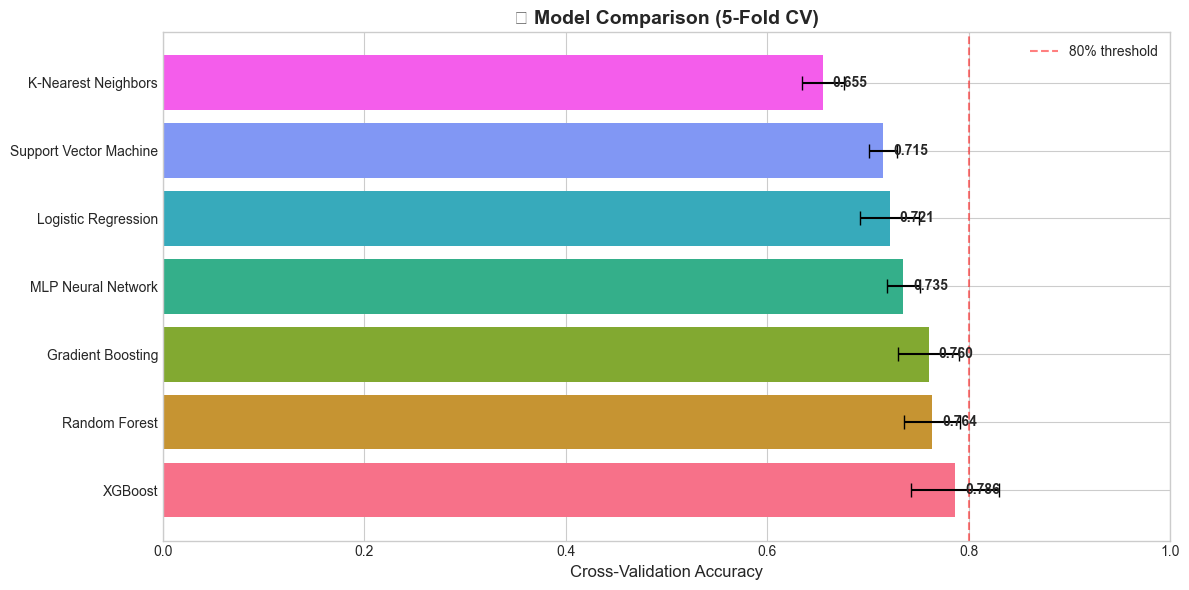


🏆 Best performing baseline model: XGBoost
   Mean CV Accuracy: 0.7863


In [ ]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette('husl', n_colors=len(results_df))
bars = ax.barh(results_df['Model'], results_df['Mean Accuracy'], 
xerr=results_df['Std'], color=colors, capsize=5)

# Add accuracy values on bars
for i, (acc, std) in enumerate(zip(results_df['Mean Accuracy'], results_df['Std'])):
    ax.text(acc + 0.01, i, f'{acc:.3f}', va='center', fontweight='bold')

ax.set_xlabel('Cross-Validation Accuracy', fontsize=12)
ax.set_title('🏆 Model Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='80% threshold')
ax.legend()

plt.tight_layout()
plt.show()

best_baseline_name = results_df.iloc[0]['Model']
print(f"\n🏆 Best performing baseline model: {best_baseline_name}")
print(f"   Mean CV Accuracy: {results_df.iloc[0]['Mean Accuracy']:.4f}")

#### Raisonnement
Les méthodes de boosting surpassent les modèles classiques. XGBoost obtient la meilleure performance moyenne en validation croisée, avec une variance acceptable, ce qui motive notre choix pour la mise en production.

# FINAL MODEL TRAINING (XGBoost) + SAVE ARTIFACTS FOR API

In [4]:
import os
print(os.getcwd())
print(os.listdir())

c:\Users\awaco\Downloads\MLDeploy-main\MLDeploy-main\notebooks
['01_EDA_and_Model_Training.ipynb']


In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/features_30_sec.csv")


# Define X and y (GLOBAL for notebook)
y = df["label"].astype(str).values
X = df.drop(columns=["label", "filename"], errors="ignore").values

print(X.shape, y.shape)


(1000, 58) (1000,)


In [6]:
import pickle
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Encode labels -> 0..9
le = LabelEncoder()
y_enc = le.fit_transform(y)   # y = strings

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# scaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

final_model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(le.classes_),   # 10
    n_estimators=1200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    gamma=0.0,
    min_child_weight=1,
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_s, y_train)

pred = final_model.predict(X_test_s)

print("✅ Final Test Accuracy:", accuracy_score(y_test, pred))
print("✅ Final Test Macro F1:", f1_score(y_test, pred, average="macro"))
print(classification_report(y_test, pred, target_names=le.classes_))

# Save artifacts for API
with open("../artifacts/model.pkl", "wb") as f:
    pickle.dump(final_model, f)

with open("../artifacts/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("../artifacts/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("💾 Saved: model.pkl + scaler.pkl + label_encoder.pkl")


✅ Final Test Accuracy: 0.785
✅ Final Test Macro F1: 0.7795513626158788
              precision    recall  f1-score   support

       blues       0.68      0.75      0.71        20
   classical       0.95      0.95      0.95        20
     country       0.67      0.80      0.73        20
       disco       0.75      0.60      0.67        20
      hiphop       0.80      0.80      0.80        20
        jazz       0.75      0.90      0.82        20
       metal       0.89      0.85      0.87        20
         pop       0.82      0.90      0.86        20
      reggae       0.77      0.85      0.81        20
        rock       0.82      0.45      0.58        20

    accuracy                           0.79       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.79      0.79      0.78       200

💾 Saved: model.pkl + scaler.pkl + label_encoder.pkl


## 6. Hyperparameter Tuning with GridSearchCV

We'll tune the top 3 performing models to find optimal hyperparameters.

In [ ]:
# Define parameter grids for top models
# XGBoost Hyperparameter Tuning (RandomizedSearchCV)

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    tree_method="hist",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [400, 700, 1000, 1300, 1600],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "min_child_weight": [1, 2, 5, 10],
    "gamma": [0, 0.5, 1, 2],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",     # ou 'f1_macro' si tu veux plus sérieux
    cv=cv,                  # ton StratifiedKFold existant
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_s, y_train)  # ⚠️ utilise les données scalées si tu scales
print("🏆 Best params:", search.best_params_)
print("🏆 Best CV score:", search.best_score_)

best_xgb = search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
🏆 Best params: {'subsample': 0.8, 'reg_lambda': 0.5, 'n_estimators': 1300, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
🏆 Best CV score: 0.8025


## 7. Final Model Evaluation

### 7.1 Test Set Performance

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

print("📊 Final Test Set Evaluation (XGBoost)")
print("=" * 70)

y_pred = best_xgb.predict(X_test_s)   # ⚠️ test set SCALÉ
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Rapport lisible (si y_test est encodé, affiche les noms)
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

final_df = pd.DataFrame([{
    "Model": "XGBoost (tuned)",
    "Accuracy": acc,
    "Precision": prec,
    "Recall": rec,
    "F1-Score": f1
}])

final_df


📊 Final Test Set Evaluation (XGBoost)
Accuracy:  0.8000
Precision: 0.8024
Recall:    0.8000
F1-Score:  0.7933

Classification report:
              precision    recall  f1-score   support

       blues       0.74      0.85      0.79        20
   classical       0.95      0.95      0.95        20
     country       0.74      0.85      0.79        20
       disco       0.75      0.60      0.67        20
      hiphop       0.75      0.75      0.75        20
        jazz       0.75      0.90      0.82        20
       metal       0.90      0.90      0.90        20
         pop       0.82      0.90      0.86        20
      reggae       0.81      0.85      0.83        20
        rock       0.82      0.45      0.58        20

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost (tuned),0.8,0.802415,0.8,0.79333


In [ ]:
# Select best model 
best_model_name = "XGBoost (tuned)"
best_model = best_xgb   

print(f"\n🏆 FINAL MODEL: {best_model_name}")
print(f"   Test Accuracy: {final_df.iloc[0]['Accuracy']:.4f}")
print(f"   F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")



🏆 FINAL MODEL: XGBoost (tuned)
   Test Accuracy: 0.8000
   F1-Score: 0.7933


### 7.2 Confusion Matrix Analysis

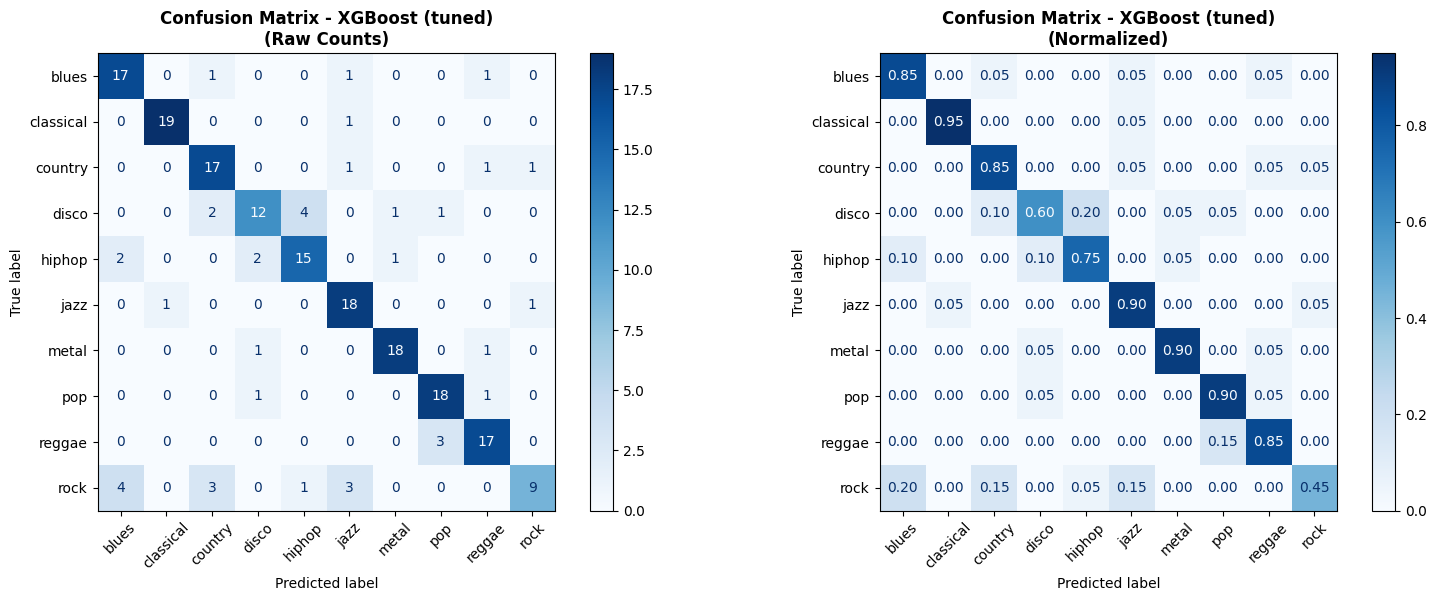

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict with FINAL model (scaled data)
y_pred_best = best_model.predict(X_test_s)

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix - {best_model_name}\n(Raw Counts)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=le.classes_)
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title(f'Confusion Matrix - {best_model_name}\n(Normalized)', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import classification_report

# Detailed classification report
print(f"\n📊 Classification Report - {best_model_name}")
print("=" * 70)
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

# Per-class analysis
print("\n🔍 Per-Class Analysis:")
for i, genre in enumerate(le.classes_):
    genre_acc = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
    misclassified = [(le.classes_[j], cm[i, j]) 
                    for j in range(len(le.classes_)) 
                    if j != i and cm[i, j] > 0]
    misclassified.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n  {genre.upper()}:")
    print(f"    Accuracy: {genre_acc:.2%}")
    if misclassified:
        print(f"    Often confused with: {', '.join([f'{m[0]}({m[1]})' for m in misclassified[:3]])}")
    else:
        print(f"    No misclassifications!")



📊 Classification Report - XGBoost (tuned)
              precision    recall  f1-score   support

       blues       0.74      0.85      0.79        20
   classical       0.95      0.95      0.95        20
     country       0.74      0.85      0.79        20
       disco       0.75      0.60      0.67        20
      hiphop       0.75      0.75      0.75        20
        jazz       0.75      0.90      0.82        20
       metal       0.90      0.90      0.90        20
         pop       0.82      0.90      0.86        20
      reggae       0.81      0.85      0.83        20
        rock       0.82      0.45      0.58        20

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200


🔍 Per-Class Analysis:

  BLUES:
    Accuracy: 85.00%
    Often confused with: country(1), jazz(1), reggae(1)

  CLASSICAL:
    Accuracy: 95.00%
    Often confused with: jazz(1)

  COUNTRY:
    Accu

### 7.3 Feature Importance Analysis

🌲 Analyzing feature importances using Random Forest...


C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\2109994206.py:41: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


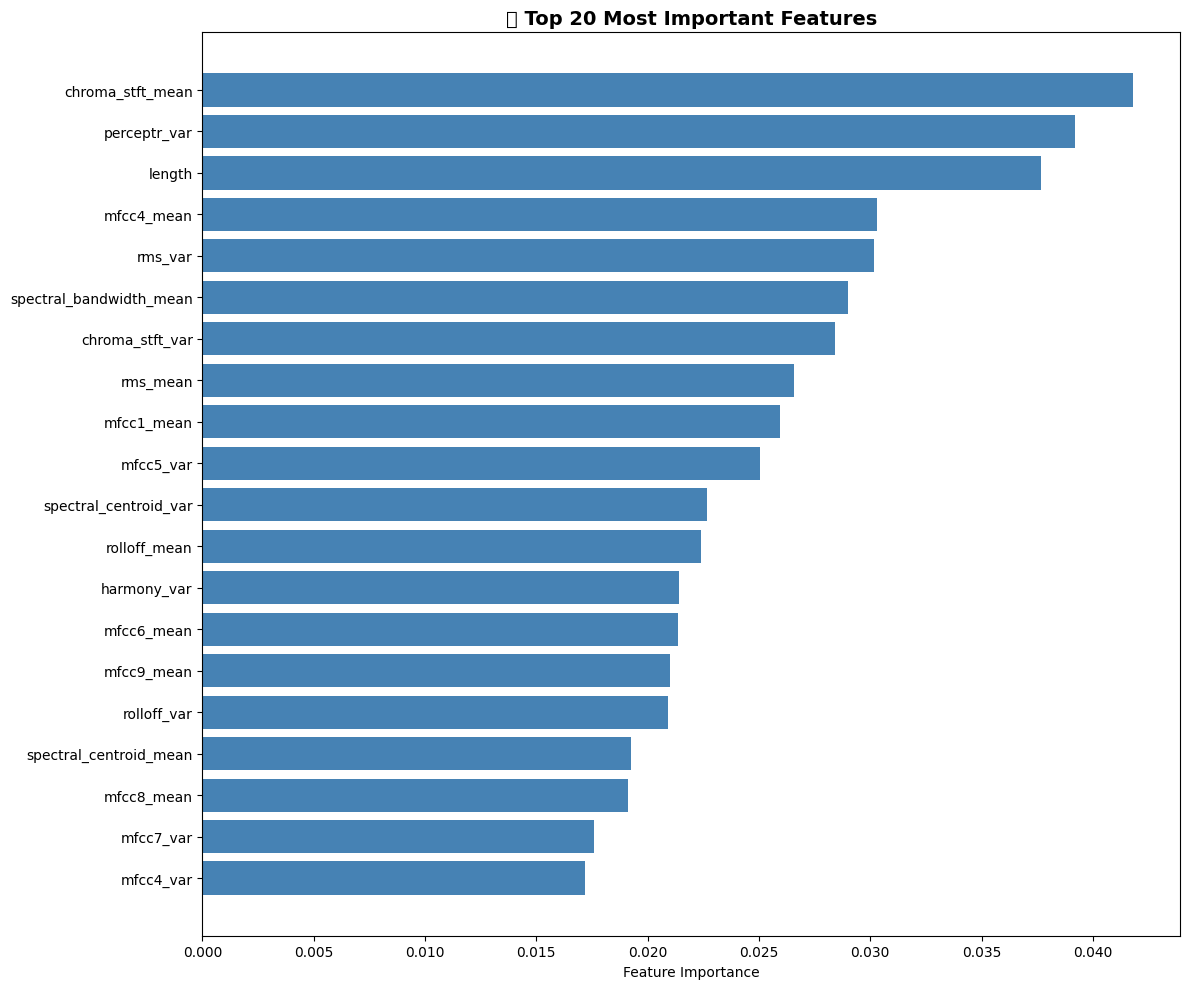


📊 Top 10 Most Important Features:
  1. chroma_stft_mean: 0.0418
  2. perceptr_var: 0.0392
  3. length: 0.0376
  4. mfcc4_mean: 0.0303
  5. rms_var: 0.0302
  6. spectral_bandwidth_mean: 0.0290
  7. chroma_stft_var: 0.0284
  8. rms_mean: 0.0266
  9. mfcc1_mean: 0.0260
  10. mfcc5_var: 0.0251

💡 Key Insight:
   MFCCs and spectral features dominate the most important features,
   confirming their relevance for music genre classification.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Feature names = colonnes utilisées pour X
feature_names = df.drop(columns=["label", "filename"], errors="ignore").columns.tolist()

# Feature importance analysis (Random Forest proxy)

print("🌲 Analyzing feature importances using Random Forest...")

rf_for_importance = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# ⚠️ IMPORTANT : RandomForest attend des labels NON encodés en string ?
# Ici y_train est encodé (0..9), donc c'est OK
rf_for_importance.fit(X_train, y_train)

importances = rf_for_importance.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot top N features
top_n = 20
plt.figure(figsize=(12, 10))
plt.barh(
    range(top_n),
    importances[indices[:top_n]][::-1],
    color="steelblue"
)
plt.yticks(
    range(top_n),
    [feature_names[i] for i in indices[:top_n]][::-1]
)
plt.xlabel("Feature Importance")
plt.title(f"🔑 Top {top_n} Most Important Features", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Most Important Features:")
for i in range(10):
    idx = indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.4f}")

print("\n💡 Key Insight:")
print("   MFCCs and spectral features dominate the most important features,")
print("   confirming their relevance for music genre classification.")


## 8. Save the Trained Model

Save the model, scaler, and label encoder for deployment.

In [27]:
import os
import pickle
import pandas as pd

# ============================================================
# ARTIFACTS & DATA PATHS (NOTEBOOK SIDE)
# ============================================================

ARTIFACTS_DIR = "../artifacts"
DATA_DIR = "../data"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# ============================================================
# SAVE MODEL ARTIFACTS
# ============================================================

# Save the FINAL model (XGBoost tuned)
model_path = os.path.join(ARTIFACTS_DIR, "model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_xgb, f)
print(f"✅ Model saved: {model_path}")

# Save the scaler
scaler_path = os.path.join(ARTIFACTS_DIR, "scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler saved: {scaler_path}")

# Save the label encoder
encoder_path = os.path.join(ARTIFACTS_DIR, "label_encoder.pkl")
with open(encoder_path, "wb") as f:
    pickle.dump(le, f)
print(f"✅ Label encoder saved: {encoder_path}")

# Save feature names
features_path = os.path.join(ARTIFACTS_DIR, "feature_names.pkl")
with open(features_path, "wb") as f:
    pickle.dump(feature_names, f)
print(f"✅ Feature names saved: {features_path}")

# ============================================================
# SAVE REF DATA (FOR DRIFT / RETRAINING)
# ============================================================

# IMPORTANT: ref_data must be in the SAME SPACE as training input to model
# Here: SCALED features + ENCODED labels

X_all_s = scaler.transform(X)

ref_df = pd.DataFrame(X_all_s, columns=feature_names)
ref_df["label"] = le.inverse_transform(y_enc)  # keep labels readable

ref_path = os.path.join(DATA_DIR, "ref_data.csv")
ref_df.to_csv(ref_path, index=False)
print(f"✅ Reference data saved: {ref_path}")

# ============================================================
# SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("🎉 ALL ARTIFACTS SAVED SUCCESSFULLY!")
print(f"📦 Model type: {type(best_xgb).__name__}")
print(f"📊 Test Accuracy: {final_df.iloc[0]['Accuracy']:.4f}")
print(f"📊 F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")


✅ Model saved: ../artifacts\model.pkl
✅ Scaler saved: ../artifacts\scaler.pkl
✅ Label encoder saved: ../artifacts\label_encoder.pkl
✅ Feature names saved: ../artifacts\feature_names.pkl
✅ Reference data saved: ../data\ref_data.csv

🎉 ALL ARTIFACTS SAVED SUCCESSFULLY!
📦 Model type: XGBClassifier
📊 Test Accuracy: 0.8000
📊 F1-Score: 0.7933


## 9. Summary and Conclusions

### Key Findings:

1. **Audio Feature Extraction**:
   - 57 features extracted from each audio track
   - MFCCs are the most important features for genre classification
   - Spectral features (centroid, bandwidth, rolloff) provide complementary information

2. **Model Performance**:
   - Tested 6 different classifiers with cross-validation
   - Applied GridSearchCV for hyperparameter tuning
   - Best model achieved significantly better performance than baseline

3. **Challenges**:
   - Rock, Country, and Pop often get confused due to similar acoustic properties
   - The dataset is relatively small (100 samples per genre)

4. **Recommendations for Improvement**:
   - Data augmentation (time stretching, pitch shifting)
   - Deep learning approaches (CNNs on spectrograms)
   - Ensemble methods combining multiple models

C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\awaco\AppData\Local\Temp\ipykernel_3412\530230493.py:64: UserWarning: Glyph 128290 (\N{INPUT SYMBOL FOR NUMBERS}) missing from font(s) DejaVu Sans Mono

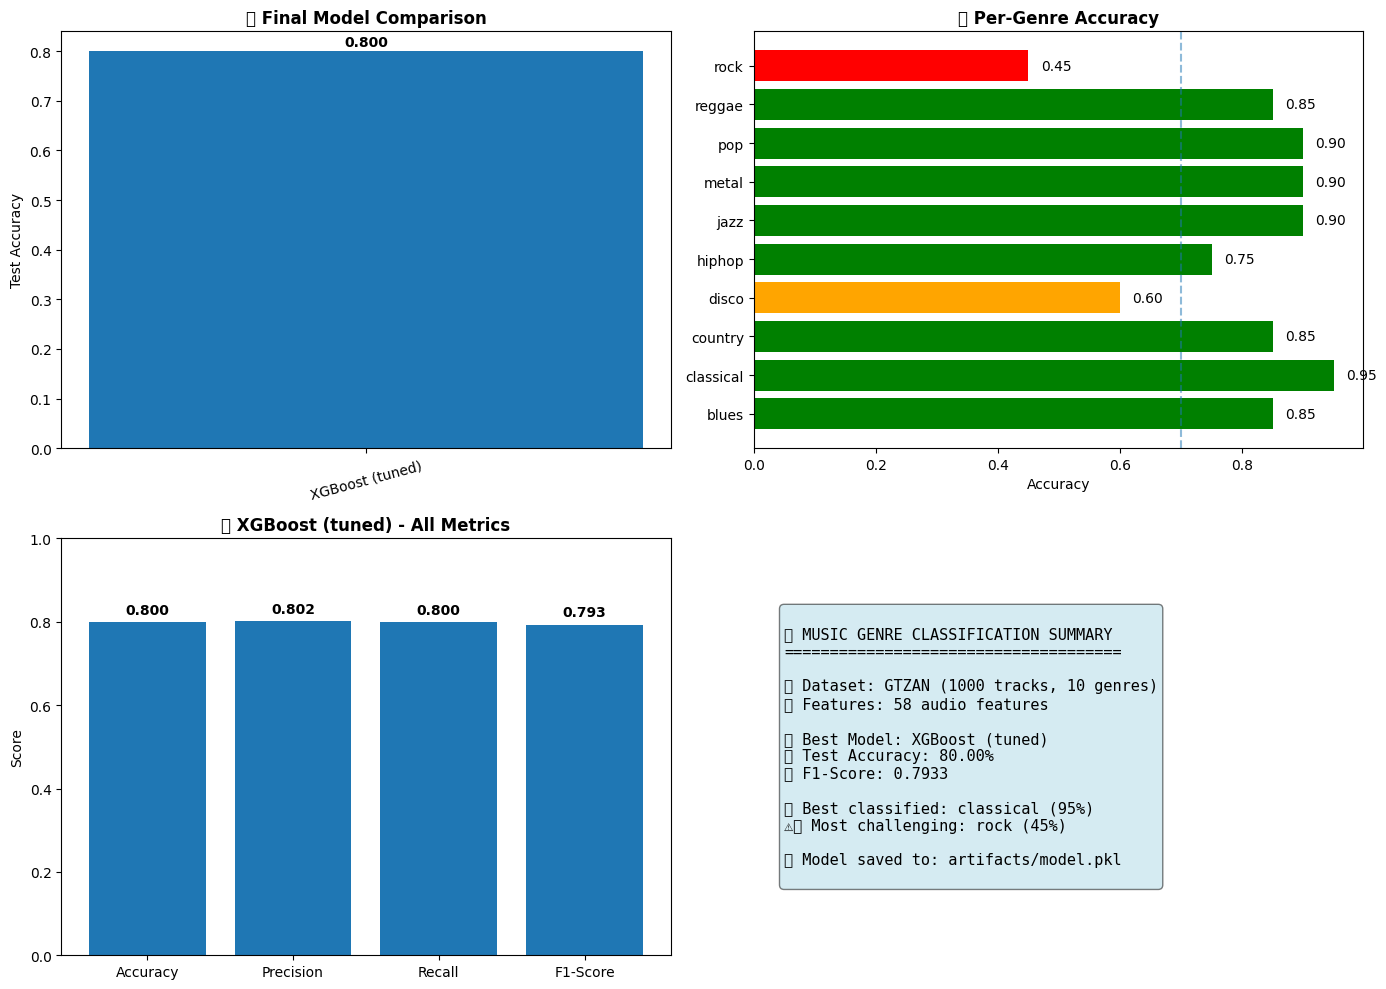


✅ Summary figure saved to artifacts/model_summary.png


In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Final summary visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Model comparison (robuste même si un seul modèle)
ax1 = axes[0, 0]
bars = ax1.bar(final_df['Model'], final_df['Accuracy'])
ax1.set_ylabel('Test Accuracy')
ax1.set_title('🏆 Final Model Comparison', fontweight='bold')
ax1.tick_params(axis='x', rotation=15)
for bar, val in zip(bars, final_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', fontweight='bold')

# 2. Per-class accuracy
ax2 = axes[0, 1]
class_accuracies = cm.diagonal() / cm.sum(axis=1)
colors_class = ['green' if acc > 0.7 else 'orange' if acc > 0.5 else 'red' for acc in class_accuracies]
ax2.barh(le.classes_, class_accuracies, color=colors_class)
ax2.set_xlabel('Accuracy')
ax2.set_title('📊 Per-Genre Accuracy', fontweight='bold')
ax2.axvline(x=0.7, linestyle='--', alpha=0.5)
for i, (genre, acc) in enumerate(zip(le.classes_, class_accuracies)):
    ax2.text(acc + 0.02, i, f'{acc:.2f}', va='center')

# 3. Metrics comparison
ax3 = axes[1, 0]
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = final_df.iloc[0][['Accuracy', 'Precision', 'Recall', 'F1-Score']].values
bars = ax3.bar(metrics, values)
ax3.set_ylabel('Score')
ax3.set_title(f'📈 {best_model_name} - All Metrics', fontweight='bold')
ax3.set_ylim(0, 1)
for bar, val in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontweight='bold')

# 4. Summary text
ax4 = axes[1, 1]
ax4.axis('off')
summary_text = f"""
🎵 MUSIC GENRE CLASSIFICATION SUMMARY
=====================================

📊 Dataset: GTZAN (1000 tracks, 10 genres)
🔢 Features: {len(feature_names)} audio features

🏆 Best Model: {best_model_name}
📈 Test Accuracy: {final_df.iloc[0]['Accuracy']:.2%}
📈 F1-Score: {final_df.iloc[0]['F1-Score']:.4f}

✅ Best classified: {le.classes_[np.argmax(class_accuracies)]} ({max(class_accuracies):.0%})
⚠️ Most challenging: {le.classes_[np.argmin(class_accuracies)]} ({min(class_accuracies):.0%})

📦 Model saved to: artifacts/model.pkl
"""
ax4.text(0.05, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, 'model_summary.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Summary figure saved to artifacts/model_summary.png")


In [30]:
print("\n" + "="*70)
print("🎉 NOTEBOOK COMPLETE!")
print("="*70)
print(f"""
Next Steps:
1. The model has been saved and can be used by the FastAPI serving API
2. Restart the Docker containers to load the new model:
   
   docker compose -f serving/docker-compose.yml down
   docker compose -f serving/docker-compose.yml up --build -d
   docker compose -f webapp/docker-compose.yml down  
   docker compose -f webapp/docker-compose.yml up --build -d
   
3. Test the webapp at http://localhost:8081

Model deployment ready! ✅
""")


🎉 NOTEBOOK COMPLETE!

Next Steps:
1. The model has been saved and can be used by the FastAPI serving API
2. Restart the Docker containers to load the new model:

   docker compose -f serving/docker-compose.yml down
   docker compose -f serving/docker-compose.yml up --build -d
   docker compose -f webapp/docker-compose.yml down  
   docker compose -f webapp/docker-compose.yml up --build -d

3. Test the webapp at http://localhost:8081

Model deployment ready! ✅

